In [12]:
#https://github.com/guillaume-chevalier/seq2seq-signal-prediction
from datetime import date, timedelta
import pandas as pd
import numpy as np
from pandas import Series, DataFrame

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.advanced_activations import PReLU
from keras.layers.normalization import BatchNormalization
from keras.layers import LSTM,GRU
from keras import callbacks
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from keras.models import Model
from keras.layers import Input, LSTM, Dense

In [13]:
df_train = pd.read_csv(
    "../../../data/sflogs/loadCPU04t.csv")

df_train = df_train.astype({"avg(cpu)":'float'})
df_train.head()

,everyDayHour,avg(cpu)
0,05/08/19_18,20.254444
1,05/08/19_19,22.451528
2,05/08/19_20,16.359259
3,05/08/19_21,10.932778
4,05/08/19_22,3.047917


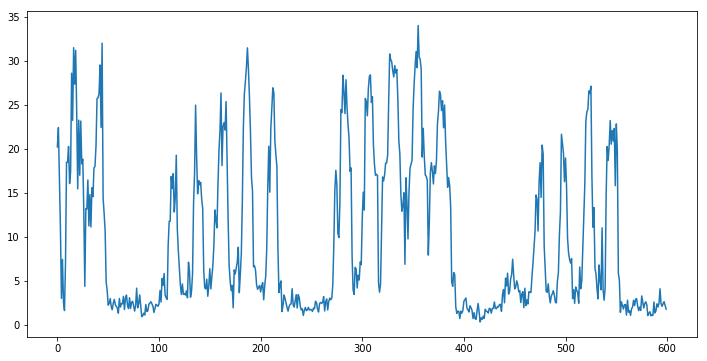

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 图形出现在Notebook里而不是新窗口
%matplotlib inline

plt.figure(figsize=(12, 6))

plt.plot(
    df_train["avg(cpu)"][:600,], 
    label="Original Data"
)

In [3]:
#df_train["hour"] =  df_train['everyDayHour'].map(lambda strDateHour: strDateHour[9:])
df_train["everyDayHour"] =  df_train['everyDayHour'].map(lambda strDateHour: "20"+strDateHour[6:8] 
                                                         + "/" + strDateHour[0:5] + " "
                                                         + strDateHour[9:11] + ":00:00")
df_train["metric"] = "cpu"
#df_train.head()

df_train["everyDayHour"] = pd.to_datetime(df_train["everyDayHour"], format='%Y%m%d %H:%M:%S')

df_train.head()

,everyDayHour,avg(cpu),metric
0,2019-05-08 18:00:00,20.254444,cpu
1,2019-05-08 19:00:00,22.451528,cpu
2,2019-05-08 20:00:00,16.359259,cpu
3,2019-05-08 21:00:00,10.932778,cpu
4,2019-05-08 22:00:00,3.047917,cpu


In [4]:
df_train = df_train.pivot(index="metric",columns="everyDayHour",values="avg(cpu)")
df_train.head()

everyDayHour,2019-05-08 18:00:00,2019-05-08 19:00:00,2019-05-08 20:00:00,2019-05-08 21:00:00,2019-05-08 22:00:00,2019-05-08 23:00:00,2019-05-09 00:00:00,2019-05-09 01:00:00,2019-05-09 02:00:00,2019-05-09 03:00:00,...,2019-11-07 13:00:00,2019-11-07 14:00:00,2019-11-07 15:00:00,2019-11-07 16:00:00,2019-11-07 17:00:00,2019-11-07 18:00:00,2019-11-07 19:00:00,2019-11-07 20:00:00,2019-11-07 21:00:00,2019-11-07 22:00:00
metric,,,,,,,,,,,,,,,,,,,,,
cpu,20.254444,22.451528,16.359259,10.932778,3.047917,7.469889,2.591429,1.671944,7.179815,18.505778,...,26.336926,30.060963,30.210574,24.985148,26.584407,21.189593,18.296315,16.747204,15.633907,15.351627


In [5]:
df_train.columns

DatetimeIndex(['2019-05-08 18:00:00', '2019-05-08 19:00:00',
               '2019-05-08 20:00:00', '2019-05-08 21:00:00',
               '2019-05-08 22:00:00', '2019-05-08 23:00:00',
               '2019-05-09 00:00:00', '2019-05-09 01:00:00',
               '2019-05-09 02:00:00', '2019-05-09 03:00:00',
               ...
               '2019-11-07 13:00:00', '2019-11-07 14:00:00',
               '2019-11-07 15:00:00', '2019-11-07 16:00:00',
               '2019-11-07 17:00:00', '2019-11-07 18:00:00',
               '2019-11-07 19:00:00', '2019-11-07 20:00:00',
               '2019-11-07 21:00:00', '2019-11-07 22:00:00'],
              dtype='datetime64[ns]', name='everyDayHour', length=4397, freq=None)

In [6]:
def get_timespan(df, datetimeStart, minus, periods, freq='H'):
    return df[pd.date_range(datetimeStart - timedelta(hours=minus), periods=periods, freq=freq)]

t2019May19 = pd.to_datetime("2019-07-19 02:00:00", format='%Y%m%d %H:%M:%S')

dfRangeData = get_timespan(df_train,t2019May19, 12, 12)

In [7]:
def prepare_dataset(df, datetimeStart, is_train=True, name_prefix=None):
    X = {}
    #for i in [2, 7, 14, 28]:
    for i in [2]:
        tmp = get_timespan(df, datetimeStart, i, i)
        #X['diff_%s_mean' % i] = tmp.diff(axis=1).mean(axis=1).values
        #X['mean_%s_decay' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
        #X['mean_%s' % i] = tmp.mean(axis=1).values
        X['median_%s' % i] = tmp.median(axis=1).values
        #X['min_%s' % i] = tmp.min(axis=1).values
        #X['max_%s' % i] = tmp.max(axis=1).values
        #X['std_%s' % i] = tmp.std(axis=1).values
    
    for i in range(1, 24):
        X['hour_%s_2019' % i] = get_timespan(df, datetimeStart, i, 1).values.ravel()
        
    
    X = pd.DataFrame(X)
    
    # start date and periods is 12 days
    if is_train:
        yInput = df[pd.date_range(datetimeStart, periods=12)].values
        yTarget = df[pd.date_range(datetimeStart + timedelta(hours=1), periods=12)].values
        return X, yInput, yTarget
    
    return X

#Z = prepare_dataset(df_train, t2019May19)
#print(Z)

In [8]:
X_l, y_lIn, y_lTg = [], [], []

t2019Jul19 = pd.to_datetime("2019-05-21 02:00:00", format='%Y%m%d %H:%M:%S')
num_hours = 3800
for i in range(num_hours):
    delta = timedelta(hours = i)
    X_tmp, y_tmp1, y_tmp2 = prepare_dataset(df_train, t2019Jul19 + delta)
    
    X_l.append(X_tmp)
    y_lIn.append(y_tmp1)
    y_lTg.append(y_tmp2)
    
X_train = pd.concat(X_l, axis=0)
print(X_train.shape)
DataFrame(X_train).to_csv("x_train_sfdc.csv")

y_trainIn = np.concatenate(y_lIn, axis=0)
y_trainTarget = np.concatenate(y_lTg, axis=0)
DataFrame(y_trainIn).to_csv("y_trainIn_sfdc.csv")
DataFrame(y_trainTarget).to_csv("y_trainTarget_sfdc.csv")

(3800, 24)


In [9]:
X_train = X_train.as_matrix()

#reshape to 3D shape for X
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

print(X_train.shape)

y_trainIn = DataFrame(y_trainIn).as_matrix()
y_trainIn = y_trainIn.reshape((y_trainIn.shape[0], y_trainIn.shape[1], 1))
print(y_trainIn.shape)

y_trainTarget = DataFrame(y_trainTarget).as_matrix()
y_trainTarget = y_trainTarget.reshape((y_trainTarget.shape[0], y_trainTarget.shape[1], 1))

(3800, 24, 1)
(3800, 12, 1)


In [10]:
batch_size = 128  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 32  # Latent dimensionality of the encoding space.
#num_samples = 150 

num_encoder_tokens = 1
num_decoder_tokens = 1

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


In [11]:
encoder_input_data = X_train

decoder_input_data = y_trainIn

decoder_target_data = y_trainTarget

# Run training
opt = optimizers.Adam(lr=0.001)
#model.compile(optimizer=opt, loss='mse',
#              metrics=['mse'])
#model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
#          batch_size=batch_size,
#          epochs=epochs,
#          validation_split=0.2)

In [12]:
print(X_train.shape)
print(y_trainTarget.shape)

def generate_x_y_data(X_train, y_trainTarget, isTrain=True, batch_size=10):
    # shape: (batch_size, seq_length, output_dim)
    idx = 0
    while True:
        if idx + batch_size > X_train.shape[0]:
            idx = 0
        start = idx
        idx += batch_size
        yield X_train[start:start+batch_size,:,:], y_trainTarget[start:start+batch_size,:,:]
    
    # shape: (seq_length, batch_size, output_dim)
    return None

generateBatch = generate_x_y_data(X_train, y_trainTarget)
xN, yN = next(generateBatch)

batch_x = np.array(xN).transpose((1, 0, 2))
batch_y = np.array(yN).transpose((1, 0, 2))
# shape: (seq_length, batch_size, output_dim)
print(batch_x.shape)
print(batch_y.shape)

(3800, 24, 1)
(3800, 12, 1)
(24, 10, 1)
(12, 10, 1)


In [13]:
import tensorflow as tf  # Version 1.0 or 0.12
import numpy as np
import matplotlib.pyplot as plt


xN, yN = next(generateBatch)

sample_x = np.array(xN).transpose((1, 0, 2))
sample_y = np.array(yN).transpose((1, 0, 2))

seq_lengthInput = sample_x.shape[0] 
seq_lengthOutput = sample_y.shape[0]
batch_size = 10  # Low value used for live demo purposes - 100 and 1000 would be possible too, crank that up!

input_dim = sample_x.shape[-1] 
output_dim = sample_y.shape[-1] 

# Output dimension (e.g.: multiple signals at once, tied in time)
layers_stacked_count = 2  # Number of stacked recurrent cells, on the neural depth axis. 

# Optmizer: 
learning_rate = 0.007  # Small lr helps not to diverge during training. 
lr_decay = 0.92  # default: 0.9 . Simulated annealing.
momentum = 0.5  # default: 0.0 . Momentum technique in weights update
lambda_l2_reg = 0.003  # L2 regularization of weights - avoids overfitting

nb_iters = 2500 # How many times we perform a training step (therefore how many times we show a batch). 
batch_size = 10 
hidden_dim = 35 # Count of hidden neurons in the recurrent units.

try:
    tf.nn.seq2seq = tf.contrib.legacy_seq2seq
    tf.nn.rnn_cell = tf.contrib.rnn
    tf.nn.rnn_cell.GRUCell = tf.contrib.rnn.GRUCell
    print("TensorFlow's version : 1.0 (or more)")
except: 
    print("TensorFlow's version : 0.12")
    

    tf.reset_default_graph()
# sess.close()
sess = tf.InteractiveSession()

with tf.variable_scope('Seq2seqPw',reuse=tf.AUTO_REUSE):

    # Encoder: inputs
    enc_inp = [
        tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
           for t in range(seq_lengthInput)
    ]

    # Decoder: expected outputs
    expected_sparse_output = [
        tf.placeholder(tf.float32, shape=(None, output_dim), name="expected_sparse_output_".format(t))
          for t in range(seq_lengthOutput)
    ]
    
    # Give a "GO" token to the decoder. 
    # Note: we might want to fill the encoder with zeros or its own feedback rather than with "+ enc_inp[:-1]"
    dec_inp = [ tf.zeros_like(enc_inp[0], dtype=np.float32, name="GO") ] + enc_inp[:-1]

    # Create a `layers_stacked_count` of stacked RNNs (GRU cells here). 
    cells = []
    for i in range(layers_stacked_count):
        with tf.variable_scope('RNN_{}'.format(i)):
            cells.append(tf.nn.rnn_cell.GRUCell(hidden_dim))
            # cells.append(tf.nn.rnn_cell.BasicLSTMCell(...))
    cell = tf.nn.rnn_cell.MultiRNNCell(cells)
    
    # Here, the encoder and the decoder uses the same cell, HOWEVER,
    # the weights aren't shared among the encoder and decoder, we have two
    # sets of weights created under the hood according to that function's def. 
    dec_outputs, dec_memory = tf.nn.seq2seq.basic_rnn_seq2seq(
        enc_inp, 
        dec_inp, 
        cell
    )
    
    # For reshaping the output dimensions of the seq2seq RNN: 
    w_out = tf.Variable(tf.random_normal([hidden_dim, output_dim]))
    b_out = tf.Variable(tf.random_normal([output_dim]))
    
    # Final outputs: with linear rescaling for enabling possibly large and unrestricted output values.
    output_scale_factor = tf.Variable(1.0, name="Output_ScaleFactor", dtype=tf.float32)
    
    reshaped_outputs = [output_scale_factor*(tf.matmul(i, w_out) + b_out) for i in dec_outputs]


# Training loss and optimizer

with tf.variable_scope('Loss',reuse=tf.AUTO_REUSE):
    # L2 loss
    output_loss = 0
    for _y, _Y in zip(reshaped_outputs, expected_sparse_output):
        output_loss += tf.reduce_mean(tf.nn.l2_loss(_y - _Y))
        
    # L2 regularization (to avoid overfitting and to have a  better generalization capacity)
    reg_loss = 0
    for tf_var in tf.trainable_variables():
        if not ("Bias" in tf_var.name or "Output_" in tf_var.name):
            reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf.cast(tf_var,tf.float32)))
            
    loss = output_loss + lambda_l2_reg * reg_loss

with tf.variable_scope('Optimizer',reuse=tf.AUTO_REUSE):
    optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=lr_decay, momentum=momentum)
    train_op = optimizer.minimize(loss)




For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

TensorFlow's version : 1.0 (or more)


In [14]:
def train_batch(batch_size):
    """
    Training step that optimizes the weights 
    provided some batch_size X and Y examples from the dataset. 
    """
    #X, Y = generate_x_y_data(isTrain=True, batch_size=batch_size)
    xN, yN = next(generateBatch)
    X = np.array(xN).transpose((1, 0, 2))
    Y = np.array(yN).transpose((1, 0, 2))
    feed_dict = {enc_inp[t]: X[t] for t in range(len(enc_inp))}
    feed_dict.update({expected_sparse_output[t]: Y[t] for t in range(len(expected_sparse_output))})
    _, loss_t = sess.run([train_op, loss], feed_dict)
    return loss_t

def test_batch(batch_size):
    """
    Test step, does NOT optimizes. Weights are frozen by not
    doing sess.run on the train_op. 
    """
    xN, yN = next(generateBatch)
    X = np.array(xN).transpose((1, 0, 2))
    Y = np.array(yN).transpose((1, 0, 2))
    
    feed_dict = {enc_inp[t]: X[t] for t in range(len(enc_inp))}
    feed_dict.update({expected_sparse_output[t]: Y[t] for t in range(len(expected_sparse_output))})
    loss_t = sess.run([loss], feed_dict)
    return loss_t[0]

In [15]:
# Training
train_losses = []
test_losses = []

sess.run(tf.global_variables_initializer())
for t in range(nb_iters+1):
    train_loss = train_batch(batch_size)
    train_losses.append(train_loss)
    
    if t % 10 == 0: 
        # Tester
        test_loss = test_batch(batch_size)
        test_losses.append(test_loss)
        print("Step {}/{}, train loss: {}, \tTEST loss: {}".format(t, nb_iters, train_loss, test_loss))

print("Fin. train loss: {}, \tTEST loss: {}".format(train_loss, test_loss))

Step 0/2500, train loss: 4395.638671875, 	TEST loss: 15395.05078125
Step 10/2500, train loss: 4884.916015625, 	TEST loss: 3112.08251953125
Step 20/2500, train loss: 4310.16015625, 	TEST loss: 4225.8681640625
Step 30/2500, train loss: 6010.4560546875, 	TEST loss: 7369.07861328125
Step 40/2500, train loss: 11890.2880859375, 	TEST loss: 7810.671875
Step 50/2500, train loss: 13392.69140625, 	TEST loss: 16966.28125
Step 60/2500, train loss: 15564.0361328125, 	TEST loss: 12861.9267578125
Step 70/2500, train loss: 6483.58984375, 	TEST loss: 9107.7705078125
Step 80/2500, train loss: 6005.0048828125, 	TEST loss: 6570.6748046875
Step 90/2500, train loss: 7520.8447265625, 	TEST loss: 6433.91162109375
Step 100/2500, train loss: 5987.73486328125, 	TEST loss: 12061.8359375
Step 110/2500, train loss: 14176.4765625, 	TEST loss: 8389.9677734375
Step 120/2500, train loss: 7557.46240234375, 	TEST loss: 12332.8701171875
Step 130/2500, train loss: 8849.779296875, 	TEST loss: 6896.166015625
Step 140/2500, t

In [ ]:
# Test
nb_predictions = 5
print("Let's visualize {} predictions with our signals:".format(nb_predictions))

#X, Y = generate_x_y_data(isTrain=False, batch_size=nb_predictions)
xN, yN = next(generateBatch)
X = np.array(xN).transpose((1, 0, 2))
Y = np.array(yN).transpose((1, 0, 2))
    
feed_dict = {enc_inp[t]: X[t] for t in range(seq_lengthInput)}
outputs = np.array(sess.run([reshaped_outputs], feed_dict)[0])

for j in range(nb_predictions): 
    plt.figure(figsize=(12, 3))
    
    for k in range(output_dim):
        past = X[:,j,k]
        expected = Y[:,j,k] 
        pred = outputs[:,j,k]
        
        label1 = "Seen (past) values" if k==0 else "_nolegend_"
        label2 = "True future values" if k==0 else "_nolegend_"
        label3 = "Predictions" if k==0 else "_nolegend_"
        plt.plot(range(len(past)), past, "o--b", label=label1)
        plt.plot(range(len(past), len(expected)+len(past)), expected, "x--b", label=label2)
        plt.plot(range(len(past), len(pred)+len(past)), pred, "o--y", label=label3)
    
    plt.legend(loc='best')
    plt.title("Predictions v.s. true values")
    plt.show()

Let's visualize 5 predictions with our signals:


In [ ]:
x = torch.zeros(5,4)
x